In [7]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import os
import requests
import tarfile

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import resnet50

Device: cuda
Imagenette found, skipping download.
All classes are recognized.


ResNet50 training on Imagenette
Computing UMAP (epoch 0)...


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


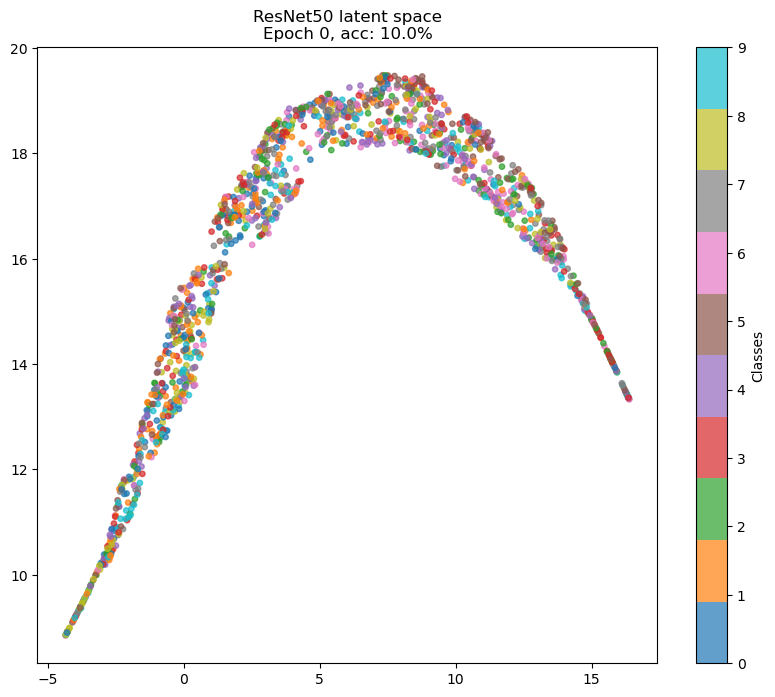

Epoch 1/10 - Loss: 1.9312
Epoch 2/10 - Loss: 1.3608
Computing UMAP (epoch 2)...


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


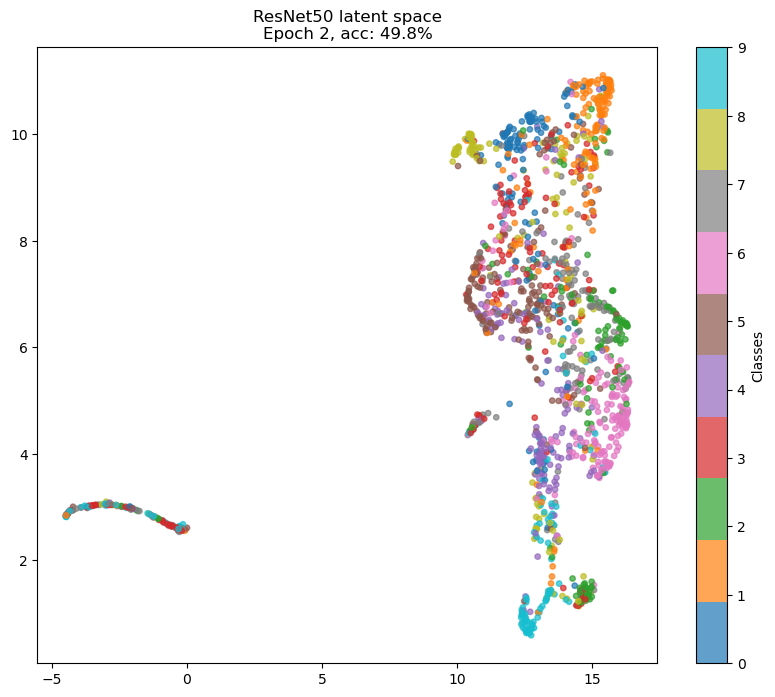

Epoch 3/10 - Loss: 1.1125
Epoch 4/10 - Loss: 0.9276
Computing UMAP (epoch 4)...


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


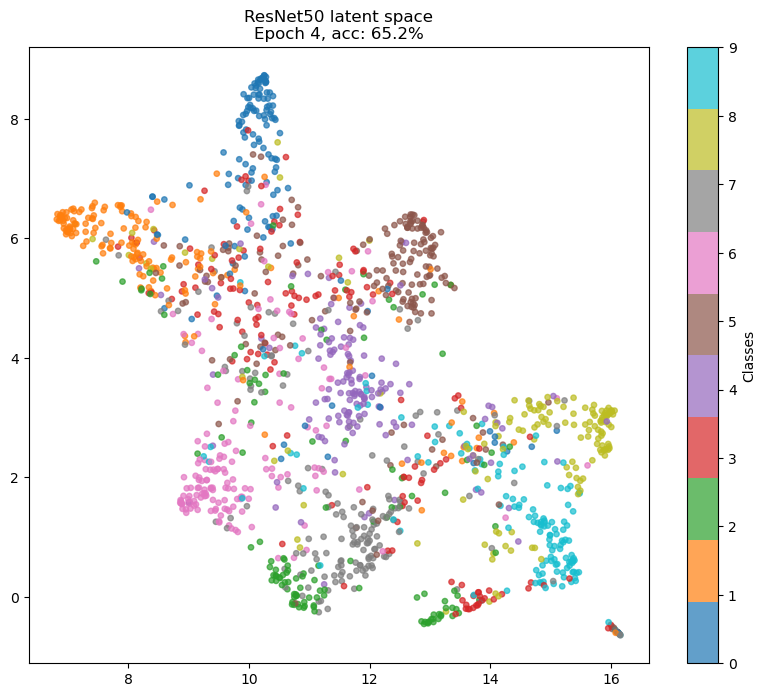

Epoch 5/10 - Loss: 0.8176
Epoch 6/10 - Loss: 0.7024
Computing UMAP (epoch 6)...


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


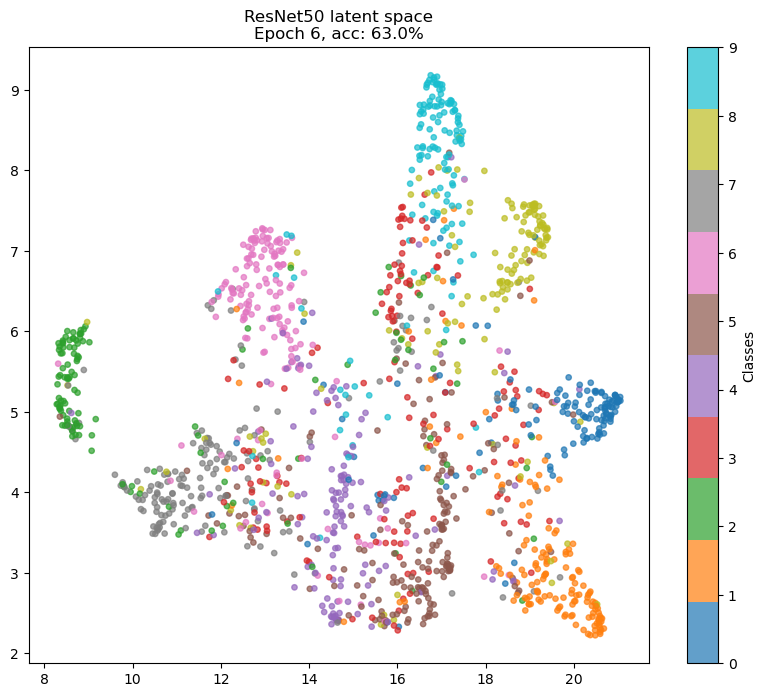

Epoch 7/10 - Loss: 0.6155
Epoch 8/10 - Loss: 0.5195
Computing UMAP (epoch 8)...


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


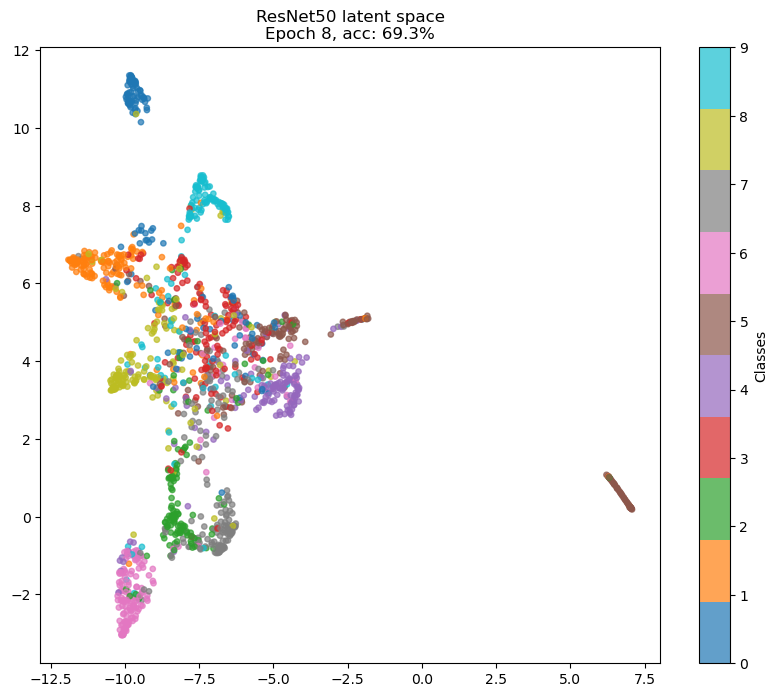

Epoch 9/10 - Loss: 0.4051
Epoch 10/10 - Loss: 0.3387
Computing UMAP (epoch 10)...


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


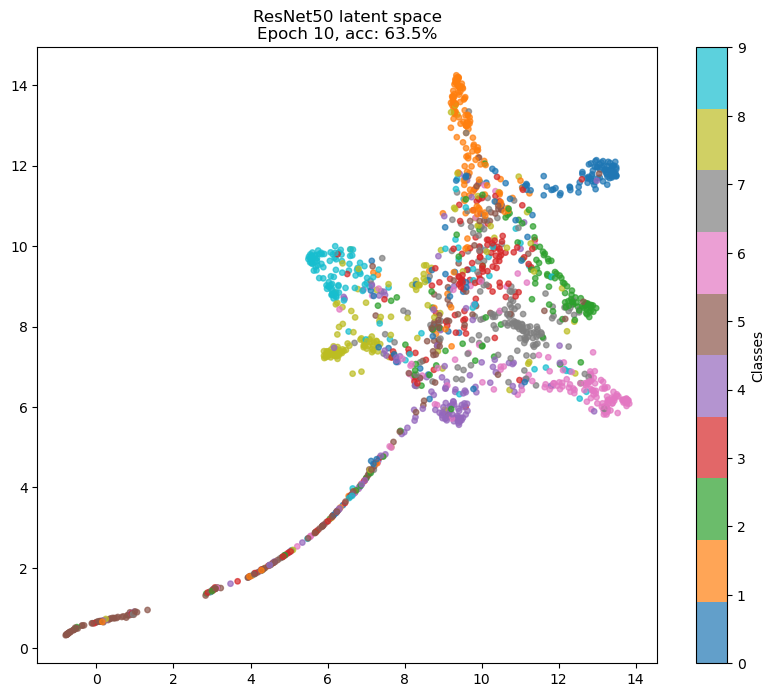

Done.

Performance analysis


C:\Users\prete\AppData\Local\Temp\ipykernel_22832\767018795.py:260: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


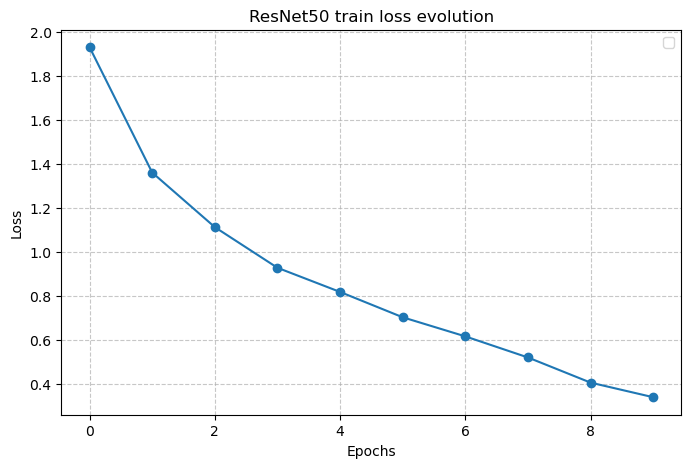

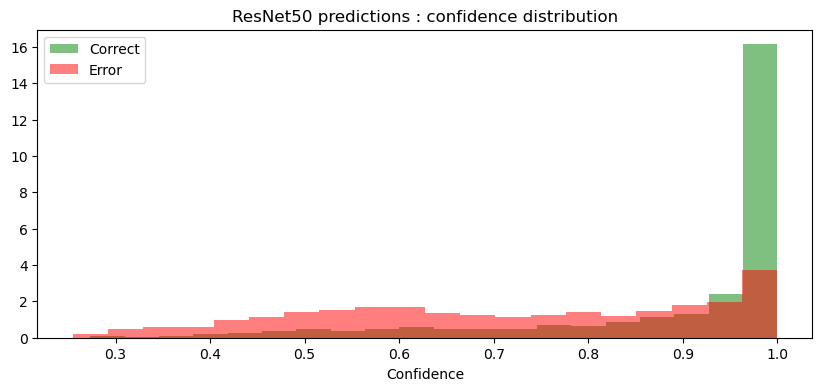

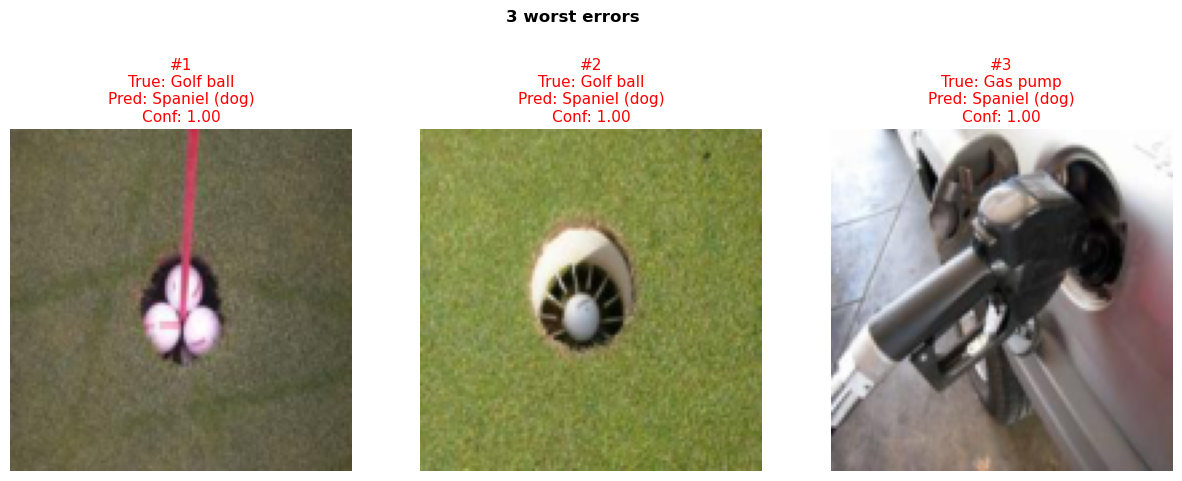

In [ ]:
# ========================================
# Configuration
# ========================================

batchSize = 64
learningRate = 0.001
numEpochs = 10
umapFreq = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ========================================
# Imagenette
# ========================================

def downloadImagenette(root='./data'):
    """
    Downloads Imagenette (160px) and stores it in the specified root directory (creates folder if needed).
    """
    url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
    filename = "imagenette2-160.tgz"
    filepath = os.path.join(root, filename)
    extractPath = os.path.join(root, "imagenette2-160")

    if not os.path.exists(root):
        os.makedirs(root)

    # If the extracted folder already exists, do nothing
    if os.path.exists(extractPath):
        print("Imagenette found, skipping download.")
        return extractPath

    print(f"Downloading Imagenette from {url}...")
    response = requests.get(url, stream=True)
    with open(filepath, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    with tarfile.open(filepath, 'r:gz') as tar:
        tar.extractall(path=root)
    
    print("Done.")
    return extractPath

dataPath = downloadImagenette()
trainDir = os.path.join(dataPath, 'train')
valDir = os.path.join(dataPath, 'val')

# Reuse transform from previous hands-on
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainDataset = torchvision.datasets.ImageFolder(trainDir, transform=transform)
valDataset = torchvision.datasets.ImageFolder(valDir, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
valLoader = torch.utils.data.DataLoader(valDataset, batch_size=batchSize, shuffle=False)

# Create a subset of 1500 random images from the validation set for UMAP visualization
indices = np.random.choice(len(valDataset), 1500, replace=False)
subsetImages = torch.stack([valDataset[i][0] for i in indices]).to(device)
subsetLabels = np.array([valDataset[i][1] for i in indices])

# ========================================
# Imagenette labels mapping for readability
# ========================================

imagenetteMapping = {
    'n01440764': 'Tench (fish)',
    'n02102040': 'Spaniel (dog)',
    'n02979186': 'Cassette player',
    'n03000684': 'Chainsaw',        # specific code in Imagenette v2
    'n03028079': 'Church',
    'n03394916': 'French horn',
    'n03417042': 'Garbage truck',
    'n03425413': 'Gas pump',
    'n03445777': 'Golf ball',       # also a specific code
    'n03888257': 'Parachute'
}

# Verify classes are right
rawClasses = trainDataset.classes
readableClasses = []
allMapped = True
for c in rawClasses:
    name = imagenetteMapping.get(c, c)
    readableClasses.append(name)
    if c not in imagenetteMapping:
        print(f"Unknown class {c}")
        allMapped = False
if allMapped:
    print("All classes are recognized.\n")

# ========================================
# Model and tools
# ========================================

class SimpleResNet50(nn.Module):
    def __init__(self, numClasses=10):
        super(SimpleResNet50, self).__init__()
        # Load empty model and only change output layer
        base = resnet50(weights=None) 
        self.body = nn.Sequential(*list(base.children())[:-1])
        self.head = nn.Linear(2048, numClasses)

    def forward(self, x):
        # Feature extraction
        x = self.body(x)
        x = x.flatten(1)
        # Classification
        return self.head(x), x

def visualizeUMAP(features, labels, epoch, acc):
    """ Visualizes the UMAP projection of the given features. 
    
    :param features: Tensor of features
    :param labels: Corresponding labels
    :param epoch: Current epoch number
    :param acc: Current accuracy
    """
    print(f"Computing UMAP (epoch {epoch})...")
    featuresNP = features.detach().cpu().numpy() # convert to numpy
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(featuresNP)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=15, alpha=0.7)
    plt.colorbar(scatter, label='Classes')
    plt.title(f"ResNet50 latent space\nEpoch {epoch}, acc: {acc:.1f}%")
    plt.show()

def analyzePredictionsWithErrors(model, dataset, title="Analysis"):
    """ Plots the confidence histogram and shows up to the 3 worst errors in classification.
    
    :param model: The trained model
    :param dataset: Dataset to analyze
    :param title: Title for the analysis"""
    model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
    allProbs, allPreds, allTargets = [], [], []
    
    # Collect all predictions
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            if isinstance(logits, tuple): logits = logits[0]
            probs = F.softmax(logits, dim=1)
            allProbs.append(probs.cpu())
            allPreds.append(probs.argmax(dim=1).cpu())
            allTargets.append(y)

    probs = torch.cat(allProbs)
    preds = torch.cat(allPreds)
    targets = torch.cat(allTargets)
    confidences = probs.max(dim=1).values # confidence is max probability
    correctMask = preds == targets # boolean mask of correct predictions
    
    # Histogram
    plt.figure(figsize=(10, 4))
    plt.hist(confidences[correctMask].numpy(), bins=20, alpha=0.5, color='green', label='Correct', density=True)
    plt.hist(confidences[~correctMask].numpy(), bins=20, alpha=0.5, color='red', label='Error', density=True) # use ~ as NOT operator
    plt.title(f"{title} : confidence distribution")
    plt.xlabel("Confidence")
    plt.legend()
    plt.show()
    
    # Worst errors
    wrongIndices = torch.where(~correctMask)[0] # again use ~ for NOT
    if len(wrongIndices) > 0:
        sortedIndices = torch.argsort(confidences[wrongIndices], descending=True)
        numError = min(3, len(sortedIndices)) # show up to 3 worst errors
        bestWrongIndices = wrongIndices[sortedIndices[:numError]] # get top worst errors (name is ironic)
        
        plt.figure(figsize=(15, 6))
        plt.suptitle(f"{numError} worst errors", fontweight='bold')
        for i, idx in enumerate(bestWrongIndices):
            plt.subplot(1, numError, i+1)
            
            # Retrieve image via dataset index
            imgTensor, _ = dataset[idx.item()] 
            
            # Denormalization
            img = imgTensor.permute(1, 2, 0).numpy() # C x H x W -> H x W x C
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            plt.imshow(img.clip(0, 1)) # clip to avoid out of range
            plt.axis('off')
            
            # Info
            trueIdx = targets[idx].item()
            predIdx = preds[idx].item()
            
            # Using the 'readableClasses' list calculated at the start
            trueName = readableClasses[trueIdx]
            predName = readableClasses[predIdx]
            conf = confidences[idx].item()
            
            plt.title(f"#{i+1}\nTrue: {trueName}\nPredicted: {predName}\nConfidence: {conf:.2f}", fontsize=11)
            
        plt.show()
    else:
        print("No error found.")

# ========================================
# Training loop
# ========================================

print("\nResNet50 training on Imagenette")
model = SimpleResNet50(numClasses=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learningRate)
criterion = nn.CrossEntropyLoss()
lossHistoryResnet50 = []

# Visualization
model.eval()
with torch.no_grad():
    _, feats = model(subsetImages)
    visualizeUMAP(feats, subsetLabels, epoch=0, acc=10.0) # initially random so accuracy is around 10%

for epoch in range(1, numEpochs + 1):
    # Training
    model.train()
    runningLoss = 0.0
    for x, y in trainLoader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    avgLoss = runningLoss / len(trainLoader)
    lossHistoryResnet50.append(avgLoss)
    print(f"Epoch {epoch}/{numEpochs} - Loss: {avgLoss:.4f}")
    
    # UMAP visualization
    if epoch % umapFreq == 0 or epoch == numEpochs: # visualize only epochs given by umapFreq and last epoch
        model.eval()
        with torch.no_grad():
            logits, features = model(subsetImages)
            preds = torch.argmax(logits, dim=1)
            acc = (preds.cpu().numpy() == subsetLabels).mean() * 100
            visualizeUMAP(features, subsetLabels, epoch, acc)

print("Done.")

# ========================================
# Analysis
# ========================================
print("\nPerformance analysis")
plt.figure(figsize=(8, 5))
plt.plot(lossHistoryResnet50, color='tab:blue', marker='o')
plt.title("ResNet50 train loss evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

analyzePredictionsWithErrors(model, valDataset, title="ResNet50 predictions")